# Bayesian Data Analysis

This notebook provides a very simple example of Bayesian parameter estimation using the Beta-Binomial model. Both analytical and simulation-based results are presented.

## Approaches to Data Analysis

><i>"All models are wrong, but some are useful"</i> -- George Box

When performing statistical analyses, probabilistic assumptions are often made. Broadly speaking, there are three commonly used levels of assumptions (listed below).  At each level, the assumptions made increase, as does the possibility that the added assumptions are wrong, but hopefully they are useful.

### 1. Exploratory

Descriptive statistics without any probabilistic assumptions
<p>Examples include: Average, Median, Quantiles, Range, Variance, Minimum/Maximum, Histogram, and various other plots and charts</p>

<i>[Note: Quantities in items 2 & 3, below, can be scalars or vectors.]</i>

### 2. Frequentist

The basic frequentist probability model consists of a random variable or vector (RV), $X$, with a cumulative distribution function, $F$, and fixed, deterministic parameters, $\theta_1, ..., \theta_m$.
<p>$$X \sim F(x;\theta_1, ..., \theta_m)$$</p>
<p>For example, the standard normal model is $F(x; \mu, \sigma) = \Phi(\frac{x-\mu}{\sigma})$,</p>
<p>where $\frac{d}{dz}\Phi(z) = \phi(z) = \frac{1}{\sqrt {2\pi}} e^{-z^2/2}$</p>

### 3. Bayesian

The basic Bayesian probability model is similar to the Frequentist model except that it goes a step further and assumes that the parameters, themselves, are RVs with their own cumulative distribution functions and parameters (e.g., $G$ and $\gamma$, resp. below).

>For example,
><p>$(X \mid \Theta=\theta) \sim F(x;\theta)$, called the <b>Likelihood Distribution</b></p>
><p>$\Theta \sim G(\theta;\gamma)$, called the <b>Prior Distribution</b></p>
><p>$\gamma$ is called a <b>hyperparameter</b> and is usually deterministic</p>

To make inferences about a Frequentist or Bayesian probability model of $X$ it is necessary to estimate the parameters of the model, $F$.

In the Frequentist case, the Maximum Likelihood Estimate (MLE) is typically derived. The MLE is a deterministic value.

In the Bayesian case, we assume we know the prior distributions of the parameters of $F$, so we seek to understand how observed values of $X$ affect that prior knowledge.  To do this, we need to obtain the conditional probability distribution of the parameters, given the observed data:

>$P(\Theta \mid X=x)$, called the <b>Posterior Distribution</b>

Depending on the type of likelihood and prior, the analytical derivation of the posterior might be intractable, so simulation is used to approximate it.  A simple example of such a simulation follows.

## Beta-Binomial Example

This is a simple and often-sited example of Bayesian parameter estimation. The posterior distribution can be analytically derived. Also, the prior and posterior are from the same family of distributions, [Beta](https://en.wikipedia.org/wiki/Beta_distribution), and so the prior distribution is called a <b>Conjugate Distribution for the likelihood</b>.

### The Data

Assume that we've conducted an experiment consisting of $n$ [binomial trials](https://en.wikipedia.org/wiki/Binomial_distribution) with an unknown probability of success, $\theta$, and that we've observed $k_{obs}$ successes.

We'll use the following values for this example:

In [7]:
n = 20  # Number of trials
k_obs = 6  # Number of observed successes in n trials

### The Frequentist Binomial Model

Here, the parameter, $\theta$, is an unknown deterministic value.
<p>$$K \sim Binomial_n(k;\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$$</p>
<p>where $n \in \mathbb{N}$, $k \in \{0, ... ,n\}$, and $\theta \in [0,1]$</p>

In [8]:
print(f"The MLE estimate of theta is k_obs/n = {k_obs}/{n} = {k_obs/n}")

The MLE estimate of theta is k_obs/n = 6/20 = 0.3


### The Bayesian Beta-Binomial Model

#### Likelihood

Probabilistic model of the data, given a specific value of the parameter:

$$(K \mid \Theta=\theta) \sim Binomial_n(k;\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$$

#### Prior

Probabilistic model of the parameter:

$$\Theta \sim Beta(\theta; \alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$$
<p>where $\theta \in [0,1]$, $\alpha > 0$, and $\beta > 0$</p>
<p>For this example, we'll assume $\Theta \sim Beta(1, 1)$, which is equivalent to the Uniform distribution:</p>
<p>$$Beta(1,1) \equiv U(0,1)$$</p>

In [9]:
# Beta prior distribution parameters used for this example
pre_alpha = 1
pre_beta = 1

#### Posterior

The Beta-Binomial posterior can be derived analytically using Bayes Theorem:
<p><center><b>Posterior $\propto$ Likelihood $\times$ Prior</b></center></p>
<p>Noting the similarity between the Binomial and Beta distributions, above, we can perform algebraic manipulations to arrive at the following result:</p>
<p>$$(\Theta \mid K=k) \sim Beta(\theta; \alpha+k, \beta+n-k)$$</p>

In [10]:
post_alpha = pre_alpha + k_obs
post_beta = pre_beta + n - k_obs
posterior_beta_parameters = (post_alpha, post_beta)
show_calc = f" = Beta({pre_alpha} + {k_obs}, {pre_beta} + {n} - {k_obs})"
print(f"So, the posterior distribution is Beta{posterior_beta_parameters}" + show_calc)

So, the posterior distribution is Beta(7, 15) = Beta(1 + 6, 1 + 20 - 6)


#### Plot of the Posterior Density

Since the prior distribution here is a $Beta(1,1)$, which is equivalent to a <i>Uniform(0,1)</i> distribution, we'll skip plotting it and jump right into plotting the posterior distribution.  Remember, this is the exact, analytically-derived posterior distribution for this example.  We'll also include a confidence interval for comparison to Bayesian <i>credible intervals</i> that we'll compute later.

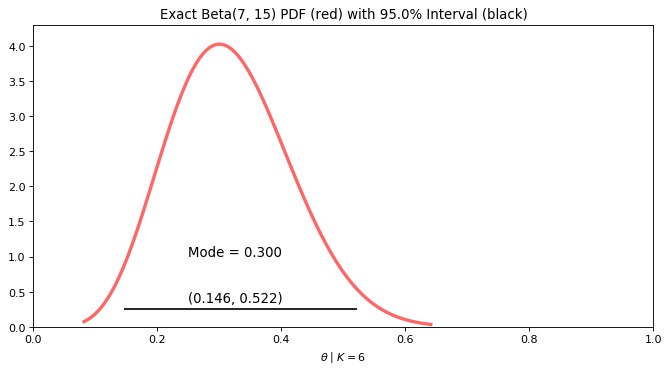

In [11]:
from scipy.stats import uniform, binom, beta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Exact Beta mode
beta_mode = (post_alpha - 1) / (post_alpha + post_beta - 2)
mode_label = f"Mode = {beta_mode:0.3f}"

# Exact Confidence Interval
conf_int_size = 0.95
p1 = (1 - conf_int_size)/2
ci_low, ci_high = beta.ppf([p1, 1-p1], *posterior_beta_parameters)
ci_label = f"({ci_low:0.3f}, {ci_high:0.3f})"

x = np.linspace(beta.ppf(0.001, *posterior_beta_parameters),
                beta.ppf(0.999, *posterior_beta_parameters), 100)
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta \mid K = $" + f"{k_obs}")
plt.title(f"Exact Beta{posterior_beta_parameters} PDF (red) with {100 * conf_int_size:0.1f}% Interval (black)")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 4.3)
plt.hlines(0.25, ci_low, ci_high, colors='k', linestyles='solid')
plt.text(0.25, 0.35, ci_label, color='k', fontsize='large')
plt.text(beta_mode - 0.05, 1.0, mode_label, color='k', fontsize='large')
_ = plt.plot(x, beta.pdf(x, *posterior_beta_parameters), 'r-', lw=3, alpha=0.6)

In the next section, we'll use a very simple simulation approach to derive an approximation to the beta-binomial posterior distribution.

### A Simple Simulation-Based Derivation of the Posterior

> <i>"We could call Bayesian data analysis 'statistics using conditional probability', but that wouldn’t put the butts in the seats."</i>  
> <p>-- Andrew Gelman</p>

This section illustrates how the beta-binomial posterior density can be derived using simulation.

The approach here is very simple for pedagogical purposes.  It does <b>NOT</b> use MCMC, which will be illustrated later.

To do this, we'll work with two lists of $\theta$'s:

* <b><i>priors</i></b>: a list of $m$ independent <i>Uniform(0,1)</i> random numbers

* <b><i>posteriors</i></b>: the subset of priors that, when used in a $Binomial_n(k;\theta)$ trial, result in $k_{obs}$ successes

In [12]:
m = 500_000  # Number of priors

priors = uniform.rvs(size=m)
posteriors = [theta for theta in priors if binom.rvs(n, theta)==k_obs]

print(f"\nThere were {len(posteriors)} matches out of {m} priors. (Only {100*len(posteriors)/m:0.2}% matched)")


There were 23514 matches out of 500000 priors. (Only 4.7% matched)


Below, is a scaled histogram of the values in the posteriors list, overlayed with the exact beta PDF, determined above.  An approximate <b>Credible Interval</b> is also displayed, along with an approximate <b>Maximum A Posterior (MAP)</b> estimate of the parameter, $\theta$.  The MAP is to Bayesians, what the MLE is to Frequentists.

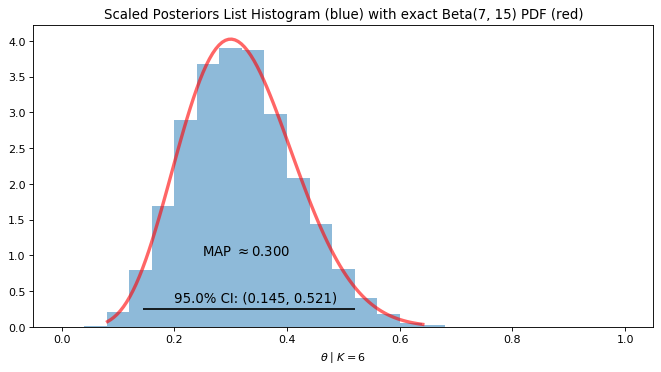

In [13]:
# Approximate Confidence Interval
from scipy.stats.mstats import mquantiles

# Compute the credible interval from the posteriors list
simp_ci_low, simp_ci_high = mquantiles(posteriors, prob=[p1, 1-p1])
simp_ci_label = f"{100 * conf_int_size:0.1f}% CI: ({simp_ci_low:0.3f}, {simp_ci_high:0.3f})"

# Plot the scaled histogram and exact Beta PDF
hbins = 25
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta \mid K = $" + f"{k_obs}")
plt.title(f"Scaled Posteriors List Histogram (blue) with exact Beta{posterior_beta_parameters} PDF (red)")
plt.plot(x, beta.pdf(x, *posterior_beta_parameters), 'r-', lw=3, alpha=0.6)
plt.hlines(0.25, simp_ci_low, simp_ci_high, colors='k', linestyles='solid')
plt.text(0.2, 0.35, simp_ci_label, color='k', fontsize='large')
ys, xs, _ = plt.hist(posteriors, bins=hbins, density=True, range=[0.0, 1.0], alpha=0.5)

# Use the histogram results to approximate the MAP
bin_index = np.argmax(ys)
mode = (xs[bin_index] + xs[bin_index + 1])/2
map_label = r"MAP $\approx$" + f"{mode:0.3f}"
_ = plt.text(mode - 0.05, 1.0, map_label, color='k', fontsize='large')

Note that the credible interval plotted above is not unique. For the same probability level, other intervals are possible. But there should be just one minimum length credible interval for a specific probability level, called the <b>Bighest Posterior Density (HPD)</b> credible interval.  We'll see how to obtain the HPD in the next section.

### MCMC-Based Derivation of the Posterior

The type of simple simulation used above is not practical for most situations.  Fortunately, there is an efficient family of simulation algorithms known as Markov Chain Monte Carlo (MCMC) methods; and there are <i>probabilistic programming</i> libraries for applying MCMC methods (e.g., PyMC3).

Here's how PyMC3 can be used to solve the problem presented above via simulation.

In [14]:
import pymc3 as pm
import warnings
warnings.simplefilter('ignore')

#### Create the Model

In [15]:
model = pm.Model()

with model:
    theta = pm.Beta("theta", alpha=pre_alpha, beta=pre_beta )
    k = pm.Binomial("k", p=theta, n=n, observed=k_obs)

model

#### Run the Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 88000/88000 [00:12<00:00, 6873.61draws/s]
The acceptance probability does not match the target. It is 0.8880845366472484, but should be close to 0.8. Try to increase the number of tuning steps.


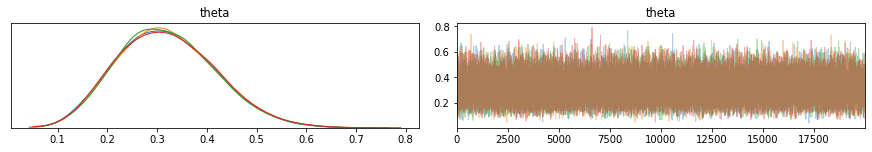

In [16]:
num_samples = 20_000

with model:
    #tr = pm.sample(num_samples, step=pm.Metropolis(), progressbar=True )
    tr = pm.sample(num_samples, tune=2000, progressbar=True )

_ = pm.traceplot(tr)

#### MAP Estimate

Here's how the MAP estimate can be obtained from PyMC3.

In [17]:
map_estimate = pm.find_MAP(model=model)
map_of_theta = float(map_estimate['theta'])

logp = -3.2978, ||grad|| = 4: 100%|██████████| 6/6 [00:00<00:00, 2948.20it/s]


In [18]:
print(f"MAP = {map_of_theta:0.3f}")

MAP = 0.300


#### Credible Interval

The dark horizontal bar in the plot, below, is the HPD for the specific requested probability level.

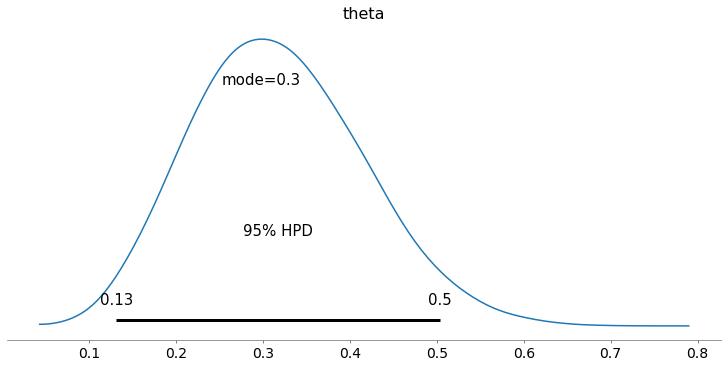

In [19]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)
_ = pm.plot_posterior(tr, credible_interval=conf_int_size, point_estimate='mode', ax=axes)

In the previous section, where a simple, non-MCMC simulation was used to simulate a list of values from the posterior distribution (<i>"posteriors"</i>), we computed a credible interval, but not the HPD.  Here is how the HPD for the <i>"posteriors"</i> list can be estimated using PyMC3.

In [20]:
simp_hpd_low, simp_hpd_high = list(pm.stats.hpd(np.array(posteriors)))
simp_hpd = f"{100 * conf_int_size:0.1f}% Simple HPD: ({simp_hpd_low:0.3f}, {simp_hpd_high:0.3f})"
print(simp_hpd)

95.0% Simple HPD: (0.138, 0.512)


#### The MCMC Simulated Data

We can obtain the simulated data, generated by PyMC3, as follows.  We'll use it to generate a plot similar to the ones already done.

In [21]:
len(tr['theta'])

80000

In [22]:
pymc_hpd_low, pymc_hpd_high = list(pm.stats.hpd(np.array(posteriors)))
pymc_hpd = f"{100 * conf_int_size:0.1f}% PyMC3 HPD: ({pymc_hpd_low:0.3f}, {pymc_hpd_high:0.3f})"
print(pymc_hpd)

95.0% PyMC3 HPD: (0.138, 0.512)


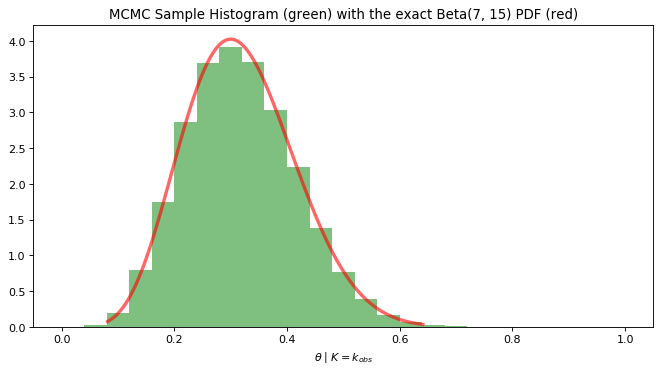

In [23]:
theta_samples = tr['theta']

fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.xlabel(r"$\theta \mid K = k_{obs}$")
plt.title(f"MCMC Sample Histogram (green) with the exact Beta{posterior_beta_parameters} PDF (red)")
plt.plot(x, beta.pdf(x, *posterior_beta_parameters), 'r-', lw=3, alpha=0.6)
_, _, _ = plt.hist(theta_samples, hbins, density=True, range=[0.0, 1.0], alpha=0.5, color='g')

### Summary & Comparison of Results

Three different approaches were used to obtain a Bayesian parameter estimate for the Beta-Binomial model:
* Exact Analytical Solution
* Simple Non-MCMC Solution
* MCMC Solution

For comparison, here are summaries of the results from each approach:

#### Exact Analytical Solution

In [24]:
print(mode_label)
print(f"{100 * conf_int_size:0.1f}% Interval: " + ci_label)

Mode = 0.300
95.0% Interval: (0.146, 0.522)


#### Simple Non-MCMC Solution

Notice that the credible interval (CI) here is very close to the exact interval, above.  That's because they were both computed in the same fashion using the respective equivalents of inverse cumulative distribution functions (i.e., in <i>scipy.stats</i> terminology: "ppf" for the exact case and "mquantile" for the simple case).

In [25]:
print(map_label)
print(simp_ci_label)
print(simp_hpd)

MAP $\approx$0.300
95.0% CI: (0.145, 0.521)
95.0% Simple HPD: (0.138, 0.512)


#### MCMC Solution

In [26]:
print(f"MAP = {map_of_theta:0.3f}")
print(pymc_hpd)

MAP = 0.300
95.0% PyMC3 HPD: (0.138, 0.512)


## End of Example

In [27]:
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()